In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import awsemtools as awt

In [2]:
trajectory = awt.Trajectory(pdb_file='awsemtools/tests/data/1r69_folding/native.pdb',dcd_file='awsemtools/tests/data/1r69_folding/movie.dcd')
view = trajectory.show_trajectory(smooth=10)
view

@> 368 atoms and 2 coordinate set(s) were parsed in 0.00s.
@> DCD file contains 402 coordinate sets for 368 atoms.
@> DCD file was parsed in 0.00 seconds.
@> 1.70 MB parsed at input rate 1182.24 MB/s.
@> 402 coordinate sets parsed at input rate 279203 frame/s.


NGLWidget(max_frame=401)

@> 368 atoms and 2 coordinate set(s) were parsed in 0.00s.
@> DCD file contains 402 coordinate sets for 368 atoms.
@> DCD file was parsed in 0.00 seconds.
@> 1.70 MB parsed at input rate 992.56 MB/s.
@> 402 coordinate sets parsed at input rate 234409 frame/s.
@> 997 atoms and 1 coordinate set(s) were parsed in 0.01s.


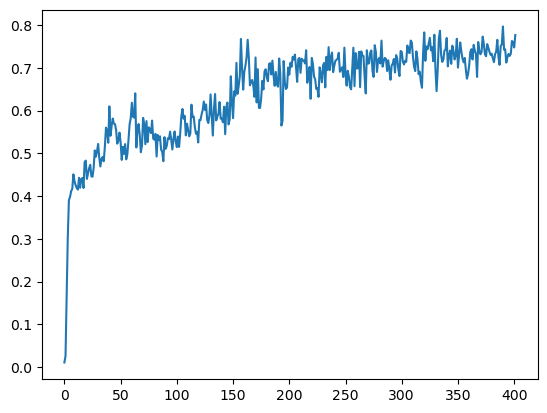

In [3]:
q = awt.q_value(trajectory, 'awsemtools/tests/data/1r69_folding/crystal_structure.pdb')
qs = q.sum(axis=(1,2))
plt.plot(qs)

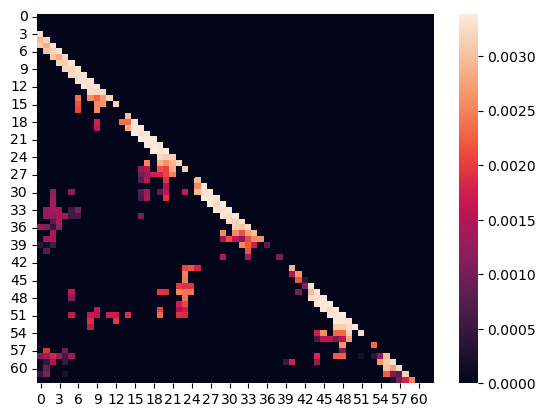

In [4]:
sns.heatmap(q.mean(axis=0))

402


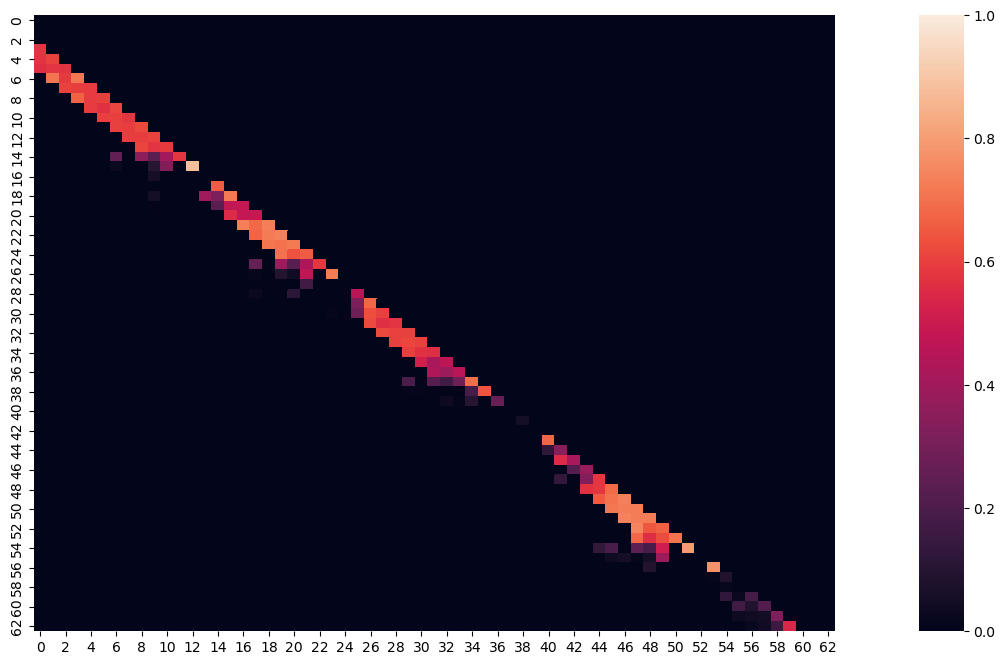

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

#Example animation of q

print(len(q))
n_frames = 100
smooth = 4
def my_func(i):
    ax.cla()
    t=len(q)//n_frames
    sns.heatmap(q[max(0,t*i-smooth):t*(i+1)+smooth].mean(axis=0)/q.max(),
                ax = ax,
                cbar = True,
                cbar_ax = cbar_ax,
                vmin = 0,
                vmax = 1)

grid_kws = {'width_ratios': (0.9, 0.05), 'wspace': 0.2}
fig, (ax, cbar_ax) = plt.subplots(1, 2, gridspec_kw = grid_kws, figsize = (12, 8))
anim = FuncAnimation(fig = fig, func = my_func, frames = 100, interval = 50, blit = False)

HTML(anim.to_html5_video())

@> 368 atoms and 2 coordinate set(s) were parsed in 0.00s.
@> DCD file contains 402 coordinate sets for 368 atoms.
@> DCD file was parsed in 0.00 seconds.
@> 1.70 MB parsed at input rate 2657.06 MB/s.
@> 402 coordinate sets parsed at input rate 627506 frame/s.
@> 997 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 997 atoms and 1 coordinate set(s) were parsed in 0.01s.


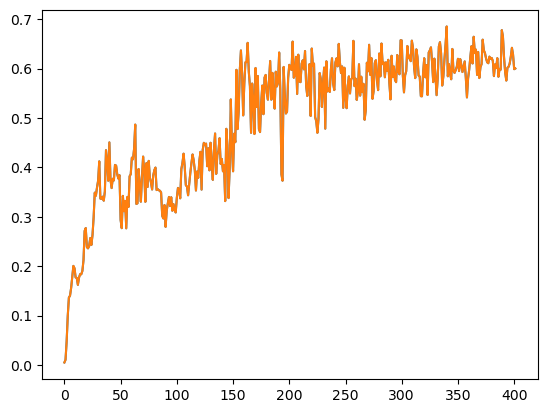

In [11]:
import numpy as np
import scipy.spatial.distance as sdist
import prody

qc = awt.q_value(trajectory, 'awsemtools/tests/data/1r69_folding/crystal_structure.pdb', contact_threshold=None)
qs = qc.sum(axis=(1,2))

#Variables
sigma_exp=0.15
min_seq_sep=3
contact_threshold=9.5
reference=prody.parsePDB('awsemtools/tests/data/1r69_folding/crystal_structure.pdb').select('name CA')

# Prepare calculation
trajectory.set_selection('name CA')
rN=sdist.squareform(sdist.pdist(reference.getCoords()))
chix = trajectory.reference.getChindices()
ix = trajectory.reference.getResindices()
sigma = np.power(np.abs(ix[:,np.newaxis]-ix[np.newaxis,:]), sigma_exp)
mask = (chix[:,np.newaxis] == chix[np.newaxis,:])*1 # Only if it is on the same chain
mask *= (ix[:,np.newaxis] - ix[np.newaxis,:] >= min_seq_sep)
#mask *= (rN <= contact_threshold)


coordset=trajectory.coords
qs2=[]
for coord in coordset:
    r=sdist.squareform(sdist.pdist(coord))
    with np.errstate(divide='ignore', invalid='ignore'):
        q=mask*np.exp(-(r-rN)**2/(2*sigma**2))
    q=np.where(mask,q,np.zeros(q.shape))
    qs2+=[q.sum()/mask.sum()]
plt.plot(qs)
plt.plot(qs2)

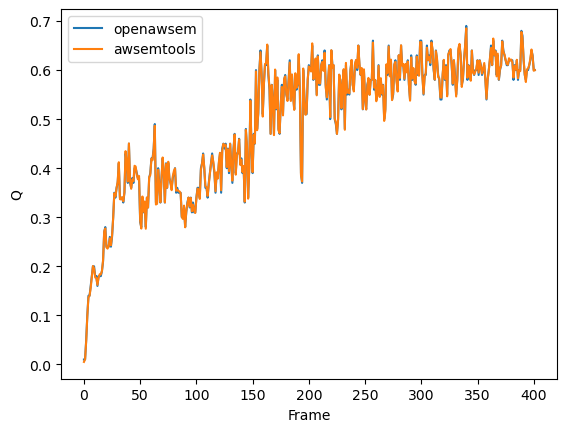

In [15]:
import pandas as pd
q_sample=pd.read_csv('awsemtools/tests/data/1r69_folding/info.dat',delim_whitespace=True)['Q']
plt.plot(q_sample)
plt.plot(qs)
plt.xlabel('Frame')
plt.ylabel('Q')
plt.legend(['openawsem','awsemtools'])

In [23]:
assert ((q_sample-qs)**2<0.01**2).all()